In [1]:
import re
import numpy as np
import collections
from sklearn import metrics
from sklearn.cross_validation import train_test_split
import tensorflow as tf
import pandas as pd
from unidecode import unidecode
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import time

/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
import malaya

In [3]:
tokenizer = malaya.preprocessing._SocialTokenizer().tokenize
rules_normalizer = malaya.texts._tatabahasa.rules_normalizer

def is_number_regex(s):
    if re.match("^\d+?\.\d+?$", s) is None:
        return s.isdigit()
    return True

def detect_money(word):
    if word[:2] == 'rm' and is_number_regex(word[2:]):
        return True
    else:
        return False

def preprocessing(string):
    tokenized = tokenizer(unidecode(string))
    tokenized = [malaya.stem.naive(w) for w in tokenized]
    tokenized = [w.lower() for w in tokenized if len(w) > 1]
    tokenized = [rules_normalizer.get(w, w) for w in tokenized]
    tokenized = ['<NUM>' if is_number_regex(w) else w for w in tokenized]
    tokenized = ['<MONEY>' if detect_money(w) else w for w in tokenized]
    return tokenized

In [4]:
def build_dataset(words, n_words):
    count = [['GO', 0], ['PAD', 1], ['EOS', 2], ['UNK', 3]]
    counter = collections.Counter(words).most_common(n_words)
    count.extend(counter)
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)
    data = list()
    unk_count = 0
    for word in words:
        index = dictionary.get(word, 3)
        if index == 0:
            unk_count += 1
        data.append(index)
    count[0][1] = unk_count
    reversed_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return data, count, dictionary, reversed_dictionary

def str_idx(corpus, dic, maxlen, UNK = 3):
    X = np.zeros((len(corpus), maxlen))
    for i in range(len(corpus)):
        for no, k in enumerate(corpus[i][:maxlen][::-1]):
            X[i, -1 - no] = dic.get(k, UNK)
    return X

In [5]:
preprocessing('kerajaan sebenarnya sangat bencikan rakyatnya, minyak naik dan segalanya jd')

['raja',
 'benar',
 'sangat',
 'benci',
 'rakyat',
 'minyak',
 'naik',
 'gala',
 'jadi']

In [6]:
import json

with open('tokenization.json') as fopen:
    dataset = json.load(fopen)
texts = dataset['texts']
labels = dataset['labels']
del dataset

In [7]:
import itertools

concat = list(itertools.chain(*texts))
vocabulary_size = len(list(set(concat)))
data, count, dictionary, rev_dictionary = build_dataset(concat, vocabulary_size)
print('vocab from size: %d'%(vocabulary_size))
print('Most common words', count[4:10])
print('Sample data', data[:10], [rev_dictionary[i] for i in data[:10]])

vocab from size: 13353
Most common words [('yang', 11804), ('untuk', 3880), ('tidak', 2898), ('deng', 2827), ('ada', 2356), ('dalam', 2194)]
Sample data [10, 70, 13, 28, 57, 54, 11, 382, 36, 187] ['filem', 'mula', 'pada', 'masa', 'lalu', 'mana', 'orang', 'budak', 'lelaki', 'nama']


In [8]:
def position_encoding(inputs):
    T = tf.shape(inputs)[1]
    repr_dim = inputs.get_shape()[-1].value
    pos = tf.reshape(tf.range(0.0, tf.to_float(T), dtype=tf.float32), [-1, 1])
    i = np.arange(0, repr_dim, 2, np.float32)
    denom = np.reshape(np.power(10000.0, i / repr_dim), [1, -1])
    enc = tf.expand_dims(tf.concat([tf.sin(pos / denom), tf.cos(pos / denom)], 1), 0)
    return tf.tile(enc, [tf.shape(inputs)[0], 1, 1])

class Model:
    def __init__(
        self,
        size_layer,
        num_layers,
        dimension_output,
        learning_rate,
        dropout,
        dict_size,
    ):
        def cells(size, reuse = False):
            return tf.contrib.rnn.DropoutWrapper(
                tf.nn.rnn_cell.LSTMCell(
                    size,
                    initializer = tf.orthogonal_initializer(),
                    reuse = reuse,
                ),
                state_keep_prob = dropout,
                output_keep_prob = dropout,
            )

        self.X = tf.placeholder(tf.int32, [None, None])
        self.Y = tf.placeholder(tf.int32, [None])
        encoder_embeddings = tf.Variable(
            tf.random_uniform([dict_size, size_layer], -1, 1)
        )
        encoder_embedded = tf.nn.embedding_lookup(encoder_embeddings, self.X)
        encoder_embedded += position_encoding(encoder_embedded)
        attention_mechanism = tf.contrib.seq2seq.BahdanauAttention(
            num_units = size_layer, memory = encoder_embedded
        )
        rnn_cells = tf.contrib.seq2seq.AttentionWrapper(
            cell = tf.nn.rnn_cell.MultiRNNCell(
                [cells(size_layer) for _ in range(num_layers)]
            ),
            attention_mechanism = attention_mechanism,
            attention_layer_size = size_layer,
            alignment_history = True,
        )
        outputs, last_state = tf.nn.dynamic_rnn(
            rnn_cells, encoder_embedded, dtype = tf.float32
        )
        self.alignments = tf.transpose(
            last_state.alignment_history.stack(), [1, 2, 0]
        )
        self.logits_seq = tf.layers.dense(outputs, dimension_output)
        self.logits_seq = tf.identity(self.logits_seq, name = 'logits_seq')
        self.logits = self.logits_seq[:, -1]
        self.logits = tf.identity(self.logits, name = 'logits')
        self.cost = tf.reduce_mean(
            tf.nn.sparse_softmax_cross_entropy_with_logits(
                logits = self.logits, labels = self.Y
            )
        )
        self.optimizer = tf.train.AdamOptimizer(
            learning_rate = learning_rate
        ).minimize(self.cost)
        correct_pred = tf.equal(
            tf.argmax(self.logits, 1, output_type = tf.int32), self.Y
        )
        self.accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
        self.attention = tf.nn.softmax(
            tf.reduce_sum(self.alignments[0], 1), name = 'alphas'
        )

In [9]:
size_layer = 256
num_layers = 2
dimension_output = 2
learning_rate = 1e-4
batch_size = 32
dropout = 0.8
maxlen = 100

tf.reset_default_graph()
sess = tf.InteractiveSession()
model = Model(
    size_layer,
    num_layers,
    dimension_output,
    learning_rate,
    dropout,
    len(dictionary),
)
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver(tf.trainable_variables())
saver.save(sess, 'bahdanau/model.ckpt')

'bahdanau/model.ckpt'

In [10]:
strings = ','.join(
    [
        n.name
        for n in tf.get_default_graph().as_graph_def().node
        if ('Variable' in n.op
        or 'Placeholder' in n.name
        or 'logits' in n.name
        or 'alphas' in n.name)
        and 'Adam' not in n.name
        and 'beta' not in n.name
    ]
)

In [11]:
strings.split(',')

['Placeholder',
 'Placeholder_1',
 'Variable',
 'memory_layer/kernel',
 'rnn/attention_wrapper/multi_rnn_cell/cell_0/lstm_cell/kernel',
 'rnn/attention_wrapper/multi_rnn_cell/cell_0/lstm_cell/bias',
 'rnn/attention_wrapper/multi_rnn_cell/cell_1/lstm_cell/kernel',
 'rnn/attention_wrapper/multi_rnn_cell/cell_1/lstm_cell/bias',
 'rnn/attention_wrapper/bahdanau_attention/query_layer/kernel',
 'rnn/attention_wrapper/bahdanau_attention/attention_v',
 'rnn/attention_wrapper/attention_layer/kernel',
 'dense/kernel',
 'dense/bias',
 'logits_seq',
 'logits',
 'alphas']

In [12]:
train_X, test_X, train_Y, test_Y = train_test_split(
    texts, labels, test_size = 0.2
)

In [13]:
from tqdm import tqdm
import time

EARLY_STOPPING, CURRENT_CHECKPOINT, CURRENT_ACC, EPOCH = 3, 0, 0, 0

while True:
    lasttime = time.time()
    if CURRENT_CHECKPOINT == EARLY_STOPPING:
        print('break epoch:%d\n' % (EPOCH))
        break

    train_acc, train_loss, test_acc, test_loss = 0, 0, 0, 0
    pbar = tqdm(
        range(0, len(train_X), batch_size), desc = 'train minibatch loop'
    )
    for i in pbar:
        batch_x = str_idx(train_X[i : min(i + batch_size, len(train_X))], dictionary, maxlen)
        batch_y = train_Y[i : min(i + batch_size, len(train_X))]
        batch_x_expand = np.expand_dims(batch_x,axis = 1)
        acc, cost, _ = sess.run(
            [model.accuracy, model.cost, model.optimizer],
            feed_dict = {
                model.Y: batch_y,
                model.X: batch_x
            },
        )
        assert not np.isnan(cost)
        train_loss += cost
        train_acc += acc
        pbar.set_postfix(cost = cost, accuracy = acc)

    pbar = tqdm(range(0, len(test_X), batch_size), desc = 'test minibatch loop')
    for i in pbar:
        batch_x = str_idx(test_X[i : min(i + batch_size, len(test_X))], dictionary, maxlen)
        batch_y = test_Y[i : min(i + batch_size, len(test_X))]
        batch_x_expand = np.expand_dims(batch_x,axis = 1)
        acc, cost = sess.run(
            [model.accuracy, model.cost],
            feed_dict = {
                model.Y: batch_y,
                model.X: batch_x
            },
        )
        test_loss += cost
        test_acc += acc
        pbar.set_postfix(cost = cost, accuracy = acc)

    train_loss /= len(train_X) / batch_size
    train_acc /= len(train_X) / batch_size
    test_loss /= len(test_X) / batch_size
    test_acc /= len(test_X) / batch_size

    if test_acc > CURRENT_ACC:
        print(
            'epoch: %d, pass acc: %f, current acc: %f'
            % (EPOCH, CURRENT_ACC, test_acc)
        )
        CURRENT_ACC = test_acc
        CURRENT_CHECKPOINT = 0
    else:
        CURRENT_CHECKPOINT += 1
        
    print('time taken:', time.time() - lasttime)
    print(
        'epoch: %d, training loss: %f, training acc: %f, valid loss: %f, valid acc: %f\n'
        % (EPOCH, train_loss, train_acc, test_loss, test_acc)
    )
    EPOCH += 1

train minibatch loop:   0%|          | 0/250 [00:00<?, ?it/s]

epoch: 0, pass acc: 0.000000, current acc: 0.567096
time taken: 75.26715779304504
epoch: 0, training loss: 0.604561, training acc: 0.654160, valid loss: 0.922054, valid acc: 0.567096



train minibatch loop:   0%|          | 0/250 [00:00<?, ?it/s]

epoch: 1, pass acc: 0.567096, current acc: 0.788705
time taken: 75.25820732116699
epoch: 1, training loss: 0.483250, training acc: 0.775003, valid loss: 0.470415, valid acc: 0.788705



train minibatch loop:   0%|          | 0/250 [00:00<?, ?it/s]

epoch: 2, pass acc: 0.788705, current acc: 0.810559
time taken: 75.37956023216248
epoch: 2, training loss: 0.399186, training acc: 0.826578, valid loss: 0.433088, valid acc: 0.810559



train minibatch loop:   0%|          | 0/250 [00:00<?, ?it/s]

epoch: 3, pass acc: 0.810559, current acc: 0.824608
time taken: 75.30173087120056
epoch: 3, training loss: 0.353495, training acc: 0.851299, valid loss: 0.422795, valid acc: 0.824608



train minibatch loop:   0%|          | 0/250 [00:00<?, ?it/s]

epoch: 4, pass acc: 0.824608, current acc: 0.836149
time taken: 75.2104640007019
epoch: 4, training loss: 0.315630, training acc: 0.870373, valid loss: 0.406607, valid acc: 0.836149



train minibatch loop:   0%|          | 0/250 [00:00<?, ?it/s]

time taken: 75.23424243927002
epoch: 5, training loss: 0.283756, training acc: 0.888443, valid loss: 0.409802, valid acc: 0.835647



train minibatch loop:   0%|          | 0/250 [00:00<?, ?it/s]

epoch: 6, pass acc: 0.836149, current acc: 0.836650
time taken: 75.21596026420593
epoch: 6, training loss: 0.252539, training acc: 0.902999, valid loss: 0.420986, valid acc: 0.836650



train minibatch loop:   0%|          | 0/250 [00:00<?, ?it/s]

time taken: 75.21621584892273
epoch: 7, training loss: 0.225280, training acc: 0.917179, valid loss: 0.446536, valid acc: 0.834142



train minibatch loop:   0%|          | 0/250 [00:00<?, ?it/s]

time taken: 75.18100953102112
epoch: 8, training loss: 0.211293, training acc: 0.923077, valid loss: 0.466832, valid acc: 0.828121



test minibatch loop: 100%|██████████| 63/63 [00:05<00:00, 11.38it/s, accuracy=0.889, cost=0.355]

time taken: 75.19368767738342
epoch: 9, training loss: 0.199609, training acc: 0.924834, valid loss: 0.530662, valid acc: 0.813068

break epoch:10



In [14]:
saver.save(sess, 'bahdanau/model.ckpt')

'bahdanau/model.ckpt'

In [15]:
text = preprocessing('kerajaan sebenarnya sangat bencikan rakyatnya, minyak naik dan segalanya')
new_vector = str_idx([text], dictionary, len(text))
sess.run(tf.nn.softmax(model.logits), feed_dict={model.X:new_vector})

array([[0.39358473, 0.6064153 ]], dtype=float32)

In [16]:
sess.run(tf.nn.softmax(model.logits_seq), feed_dict={model.X:new_vector})

array([[[0.29162458, 0.70837545],
        [0.31122   , 0.68878   ],
        [0.298804  , 0.701196  ],
        [0.34817517, 0.6518249 ],
        [0.3280444 , 0.6719556 ],
        [0.36699206, 0.633008  ],
        [0.3262662 , 0.6737338 ],
        [0.31723547, 0.6827646 ]]], dtype=float32)

In [17]:
real_Y, predict_Y = [], []

pbar = tqdm(
    range(0, len(test_X), batch_size), desc = 'validation minibatch loop'
)
for i in pbar:
    batch_x = str_idx(test_X[i : min(i + batch_size, len(test_X))], dictionary, maxlen)
    batch_y = test_Y[i : min(i + batch_size, len(test_X))]
    predict_Y += np.argmax(
        sess.run(
            model.logits, feed_dict = {model.X: batch_x, model.Y: batch_y}
        ),
        1,
    ).tolist()
    real_Y += batch_y

validation minibatch loop: 100%|██████████| 63/63 [00:05<00:00, 12.13it/s]


In [18]:
print(
    metrics.classification_report(
        real_Y, predict_Y, target_names = ['negative', 'positive']
    )
)

             precision    recall  f1-score   support

   negative       0.90      0.68      0.77       975
   positive       0.75      0.93      0.83      1018

avg / total       0.82      0.81      0.80      1993



In [19]:
import json
with open('subjectivity-dictionary.json','w') as fopen:
    fopen.write(json.dumps({'dictionary':dictionary,'reverse_dictionary':rev_dictionary}))

In [20]:
def freeze_graph(model_dir, output_node_names):

    if not tf.gfile.Exists(model_dir):
        raise AssertionError(
            "Export directory doesn't exists. Please specify an export "
            'directory: %s' % model_dir
        )

    checkpoint = tf.train.get_checkpoint_state(model_dir)
    input_checkpoint = checkpoint.model_checkpoint_path

    absolute_model_dir = '/'.join(input_checkpoint.split('/')[:-1])
    output_graph = absolute_model_dir + '/frozen_model.pb'
    clear_devices = True
    with tf.Session(graph = tf.Graph()) as sess:
        saver = tf.train.import_meta_graph(
            input_checkpoint + '.meta', clear_devices = clear_devices
        )
        saver.restore(sess, input_checkpoint)
        output_graph_def = tf.graph_util.convert_variables_to_constants(
            sess,
            tf.get_default_graph().as_graph_def(),
            output_node_names.split(','),
        )
        with tf.gfile.GFile(output_graph, 'wb') as f:
            f.write(output_graph_def.SerializeToString())
        print('%d ops in the final graph.' % len(output_graph_def.node))

In [21]:
freeze_graph('bahdanau', strings)

INFO:tensorflow:Restoring parameters from bahdanau/model.ckpt
INFO:tensorflow:Froze 11 variables.
INFO:tensorflow:Converted 11 variables to const ops.
467 ops in the final graph.


In [22]:
def load_graph(frozen_graph_filename):
    with tf.gfile.GFile(frozen_graph_filename, 'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
    with tf.Graph().as_default() as graph:
        tf.import_graph_def(graph_def)
    return graph

In [23]:
g = load_graph('bahdanau/frozen_model.pb')
x = g.get_tensor_by_name('import/Placeholder:0')
logits_seq = g.get_tensor_by_name('import/logits_seq:0')
logits = g.get_tensor_by_name('import/logits:0')
alphas = g.get_tensor_by_name('import/alphas:0')
test_sess = tf.InteractiveSession(graph = g)
result = test_sess.run([logits, alphas, logits_seq], feed_dict = {x: new_vector})

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [25]:
news_string = 'Kerajaan juga perlu prihatin dan peka terhadap nasib para nelayan yang bergantung rezeki sepenuhnya kepada sumber hasil laut. Malah, projek ini memberikan kesan buruk yang berpanjangan kepada alam sekitar selain menjejaskan mata pencarian para nelayan'

In [26]:
text = preprocessing(news_string)
new_vector = str_idx([text], dictionary, len(text))
result = test_sess.run([tf.nn.softmax(logits), alphas, tf.nn.softmax(logits_seq)], feed_dict = {x: new_vector})

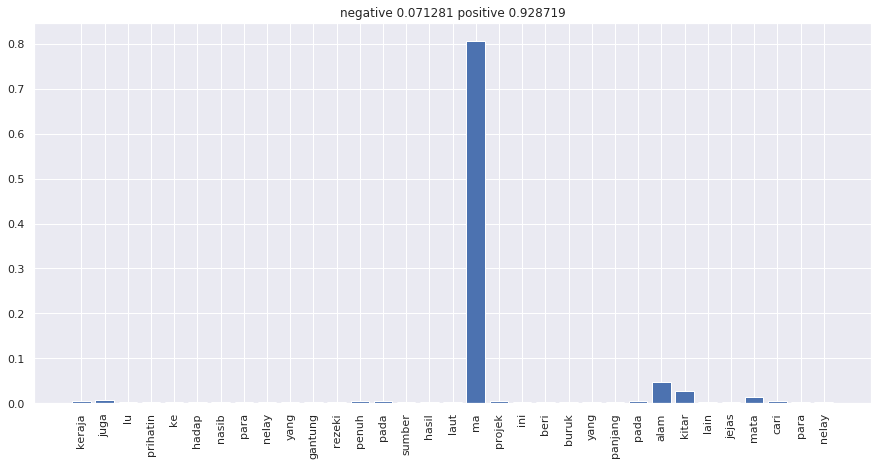

In [27]:
plt.figure(figsize = (15, 7))
labels = [word for word in text]
val = [val for val in result[1]]
plt.bar(np.arange(len(labels)), val)
plt.xticks(np.arange(len(labels)), labels, rotation = 'vertical')
plt.title('negative %f positive %f' % (result[0][0,0], result[0][0,1]))
plt.show()

In [28]:
result[2]

array([[[0.4466372 , 0.5533628 ],
        [0.46008193, 0.53991807],
        [0.48973066, 0.51026934],
        [0.5205663 , 0.47943375],
        [0.59385055, 0.40614945],
        [0.6871905 , 0.31280953],
        [0.75688523, 0.24311481],
        [0.81911033, 0.18088964],
        [0.8590312 , 0.14096877],
        [0.8096997 , 0.19030032],
        [0.8069562 , 0.19304383],
        [0.8064817 , 0.19351834],
        [0.64356893, 0.35643113],
        [0.57687825, 0.42312178],
        [0.443674  , 0.556326  ],
        [0.4030401 , 0.5969599 ],
        [0.35257795, 0.647422  ],
        [0.29474849, 0.7052515 ],
        [0.19083136, 0.8091687 ],
        [0.14468291, 0.8553171 ],
        [0.09143564, 0.9085643 ],
        [0.05756424, 0.9424357 ],
        [0.05793139, 0.94206864],
        [0.03673429, 0.9632657 ],
        [0.02543657, 0.9745634 ],
        [0.0234692 , 0.97653085],
        [0.02422071, 0.97577935],
        [0.03412079, 0.9658792 ],
        [0.02240075, 0.97759926],
        [0.042